## Import necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.layers import Dense
from keras.models import Sequential
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## Connect to Google Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Read all files and concatenate into single dataframe

In [ ]:
data_dir = '/content/drive/MyDrive/Datasets/fonts'
csv_files = !ls "{data_dir}"/*.csv
csv_files = [file.strip() for file in csv_files]
csv_files = csv_files[:len(csv_files)//2]

In [ ]:
dfs = [pd.read_csv(file) for file in csv_files]
df = pd.concat(dfs, ignore_index=True)

In [ ]:
df.head()

,font,fontVariant,m_label,strength,italic,orientation,m_top,m_left,originalH,originalW,...,r19c10,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19
0,AGENCY,AGENCY FB,64258,0.4,0,0.0,35,21,51,22,...,1,1,1,1,1,1,163,255,255,255
1,AGENCY,AGENCY FB,64257,0.4,0,0.0,35,21,51,22,...,1,1,1,1,1,1,163,255,255,255
2,AGENCY,AGENCY FB,61442,0.4,0,0.0,35,21,51,22,...,1,1,1,1,1,1,163,255,255,255
3,AGENCY,AGENCY FB,61441,0.4,0,0.0,35,21,51,22,...,1,1,1,1,1,1,163,255,255,255
4,AGENCY,AGENCY FB,9674,0.4,0,0.0,51,21,33,25,...,255,132,1,1,1,1,1,1,1,1


## Extract features and labels from dataframe

In [ ]:
features = df.iloc[:, 12:].values
labels = df['font'].values

## Plot some pictures from dataset

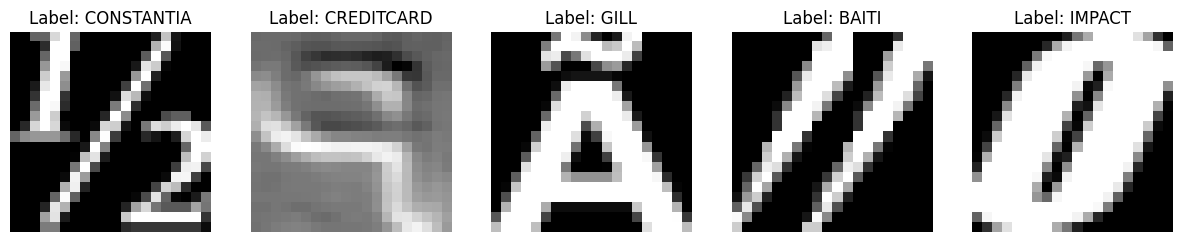

In [ ]:
num_examples_to_show = 5

random_indices = np.random.choice(len(features), num_examples_to_show, replace=False)
plt.figure(figsize=(15, 3))

for i, idx in enumerate(random_indices, 1):
    image_data = features[idx].reshape(20, 20)
    label = df['font'][idx]

    plt.subplot(1, num_examples_to_show, i)
    plt.imshow(image_data, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')

plt.show()

## Set encoder for labels, normalise values to (0, 1) range, split the data to train and test

In [ ]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

features = features.astype(np.float64) / 255

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [ ]:
X_test.shape

(68299, 400)

## Reshape the data from 400 values to 20*20 array for convolutional layers usage

In [ ]:
X_train = X_train.reshape(-1, 20, 20, 1)
X_test = X_test.reshape(-1, 20, 20, 1)

In [ ]:
X_test.shape

(68299, 20, 20, 1)

## Build the model
We are using 3 convolutional layers with 64, 128 and 256 filters respectively, with 3x3 kernels, and also only 1 MaxPooling layer. Reason for using only one pooling layer is low resolution of images (20x20), so after already single such layer resolution will be (11x11). After flatten layer, here we also use 2 dense layers with 256 and 128 neurons respectively, followed by 0.5 dropout, and output layer with number of classes (76) neurons.
As an optimizer we are using ADAM with 0.0001 learning rate and minimize sparse Cross-Entropy loss. Also we are using early stopping with 5 level patience to wait a little bit less time when learning. Model is learning during 50 epochs and using batch size 128.

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape=(20, 20, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(1, 1), strides=(1, 1)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
1708/1708 [==============================] - 579s 338ms/step - loss: 2.8456 - accuracy: 0.3569 - val_loss: 2.3653 - val_accuracy: 0.4426
Epoch 2/50
1708/1708 [==============================] - 576s 337ms/step - loss: 2.3914 - accuracy: 0.4342 - val_loss: 2.2192 - val_accuracy: 0.4580
Epoch 3/50
1708/1708 [==============================] - 581s 340ms/step - loss: 2.2529 - accuracy: 0.4533 - val_loss: 2.0931 - val_accuracy: 0.4819
Epoch 4/50
1708/1708 [==============================] - 580s 339ms/step - loss: 2.1470 - accuracy: 0.4703 - val_loss: 1.9924 - val_accuracy: 0.4969
Epoch 5/50
1708/1708 [==============================] - 587s 343ms/step - loss: 2.0640 - accuracy: 0.4822 - val_loss: 1.9240 - val_accuracy: 0.5079
Epoch 6/50
1708/1708 [==============================] - 589s 345ms/step - loss: 1.9969 - accuracy: 0.4936 - val_loss: 1.8876 - val_accuracy: 0.5189
Epoch 7/50
1708/1708 [==============================] - 596s 349ms/step - loss: 1.9390 - accuracy: 0.5035 - val_

In [ ]:
accuracy = model.evaluate(X_test, y_test)[1]
print(f'Test Accuracy: {accuracy}')

2135/2135 [==============================] - 48s 23ms/step - loss: 1.1252 - accuracy: 0.6953
Test Accuracy: 0.6952664256095886


## As a conclusion, we got a model with 69.53% accuracy, which is pretty good for 76 classes, and also we avoided the overfitting